In [ ]:
import torch
import torchvision
import random
import numpy as np


class MNIST01:
    def __init__(self):

        self.class0_samples = []
        self.class1_samples = []

        batch_size = 32 # samples per batch
        num_classes = 2

        # 32 samples per batch / 2 number of classes = ((32 / 2) * (samples / batch)) / class
        # = (16 samples per batch) / class
        # = 16 samples_per_batch_per_class

        self.samples_per_batch_per_class = int(batch_size / num_classes)

        input_nodes = 784
        l1_nodes = 1024
        l2_nodes = 32
        l3_nodes = 1

        # create batch of samples, batch_size is number of images per batch
        # or number of rows in the batch matrix.
        # each element in a row is a gray scale pixel value from 0 to 255
        self.x_batch = torch.zeros((batch_size, input_nodes))
        
        self.w1 = torch.randn(input_nodes, l1_nodes)
        self.w1 /= input_nodes**0.5

        self.b1 = torch.zeros(l1_nodes)
        
        self.w2 = torch.randn(l1_nodes, l2_nodes)
        self.w2 /= l1_nodes**0.5

        self.w3 = torch.randn(l2_nodes, l3_nodes)
        self.w3 /= l2_nodes**0.5

        self.lr = 0.001
        
    def imgs(self):
        # 60,000 samples, 28x28 pixels / sample
        self.train_dataset = torchvision.datasets.MNIST(train=True, download=True, root='./')
        
        # 10,000 samples, 28x28 pixels / sample
        self.test_dataset = torchvision.datasets.MNIST(train=False, download=True, root='./')
        
        # --------- Training dataset preparation ---------
        # Filter: class0 = 0, class1 = 1
        for i in range(len(self.train_dataset)):
            # if the img label is a 0, put the image tensor in the list of class0 samples
            # else if it's a 1, put it in the list of class1 samples
            if self.train_dataset[i][1] == 0:
                self.class0_samples.append(torch.tensor(np.array(self.train_dataset[i][0]).flatten()))
            elif self.train_dataset[i][1] == 1:
                self.class1_samples.append(torch.tensor(np.array(self.train_dataset[i][0]).flatten()))

        # stack all of the rows of tensors from the list, into a single tensor
        self.class0_stacked = torch.stack(self.class0_samples)
        self.class1_stacked = torch.stack(self.class1_samples)
        # --------------------------------------------------

        # --------- Test dataset preparation ---------------
        self.class0_test_samples = []
        self.class1_test_samples = []

        # Filter: class0 = 0, class1 = 1
        for i in range(len(self.test_dataset)):
            # if the img label is a 0, put the image tensor in the list of class0 samples
            # else if it's a 1, put it in the list of class1 samples
            if self.test_dataset[i][1] == 0:
                self.class0_test_samples.append(torch.tensor(np.array(self.test_dataset[i][0]).flatten()))
            elif self.test_dataset[i][1] == 1:
                self.class1_test_samples.append(torch.tensor(np.array(self.test_dataset[i][0]).flatten()))
        
        # stack all of the rows of tensors from the list, into a single tensor
        self.class0_test_stacked = torch.stack(self.class0_test_samples)
        self.class1_test_stacked = torch.stack(self.class1_test_samples)

    def train(self):
        # ------ forward ---------------
        for _epoch in range(1):
            samples_per_epoch = 20000
            batches = samples_per_epoch / self.samples_per_batch_per_class
            for _batch in range(int(batches)):
                class0 = self.class0_stacked[torch.randperm(len(self.class0_stacked))[:int(self.samples_per_batch_per_class)]] / 255
                class1 = self.class1_stacked[torch.randperm(len(self.class1_stacked))[:int(self.samples_per_batch_per_class)]] / 255

                self.x_batch = torch.cat([class0, class1])
                y = torch.cat([torch.zeros(self.samples_per_batch_per_class, dtype=torch.float),
                               torch.ones(self.samples_per_batch_per_class, dtype=torch.float)])
                
                y = y.view(-1,1)
                zero = torch.tensor(0.0)

                h1 = self.x_batch@self.w1 + self.b1
                relu1 = torch.maximum(zero,h1)
                
                h2 = relu1@self.w2
                relu2 = torch.maximum(zero,h2)

                h3 = relu2@self.w3
                sig3 = 1 / (1 + torch.e**(-h3))

                mse_loss = ((sig3 - y)**2).mean()

                # ------ backward ---------------
                dsig3 = 2 * (sig3 - y)
                dh3 = sig3 * (1 - sig3) * dsig3
                dh3 = dh3
                dsig2 = dh3@self.w3.T
                dsig2 = dsig2
                dw3 = relu2.T@dh3
                dh2 = (h2 > 0).float() * dsig2
                dsig1 = dh2@self.w2.T 
                dw2 = relu1.T@dh2
                dh1 = (h1 > 0).float() * dsig1
                dw1 = self.x_batch.T@dh1
                db1 = dh1.sum(dim=0)
                
                # ------ update ---------------
                self.w1 = self.w1 - self.lr * dw1
                self.w2 = self.w2 - self.lr * dw2
                self.w3 = self.w3 - self.lr * dw3
                self.b1 = self.b1 - self.lr * db1

                print(f'{mse_loss}')

    def inference(self,x):
        x = x / 255
        x = x.view(1,-1)

        h1 = x@self.w1 + self.b1

        zero = torch.tensor(0.0)
        relu1 = torch.maximum(zero,h1)
        
        h2 = relu1@self.w2
        relu2 = torch.maximum(zero,h2)

        h3 = relu2@self.w3
        sig3 = 1 / (1 + torch.e**(-h3))

        return round(sig3.item(),1)
    
    def test(self):
        class0_count = 0
        class1_count = 0

        iterations = 10000
        for i in range(iterations):
            # inputs random class0 img to model, gets prediction
            r = random.randint(0,800)
            prediction = self.inference(self.class0_test_stacked[r])  # class0 = 0, class1 = 1

            # if prediction is class0, add to count
            if prediction > 0.0 and prediction <= 0.5:
                class0_count += 1
            elif prediction > 0.5 and prediction <= 1.0:
                class1_count += 1


        print(f'accuracy %: {class0_count, class1_count}')


a = MNIST01()
a.imgs()

In [ ]:
a.class0_samples

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [2]:
a.train()

0.2530285120010376
0.24573728442192078
0.2340112328529358
0.22908031940460205
0.22727186977863312
0.21978731453418732
0.20790913701057434
0.20293796062469482
0.19515663385391235
0.19176800549030304
0.18922315537929535
0.18765723705291748
0.1813335120677948
0.17281503975391388
0.17993268370628357
0.1650952398777008
0.16834451258182526
0.15485532581806183
0.1508375108242035
0.15205305814743042
0.13566449284553528
0.1405426263809204
0.13133980333805084
0.133256733417511
0.12475813180208206
0.11798395216464996
0.1137276142835617
0.11557681113481522
0.10908301174640656
0.09840306639671326
0.10682298988103867
0.10211113095283508
0.10267925262451172
0.09530480206012726
0.0822327733039856
0.09046506136655807
0.08683402836322784
0.08615704625844955
0.08953101933002472
0.08740386366844177
0.07768820226192474
0.08261211961507797
0.07275489717721939
0.07102441042661667
0.07091057300567627
0.07340514659881592
0.06353645026683807
0.06263917684555054
0.05139404162764549
0.05509677529335022
0.06086423

In [11]:
a.test() # 10,000 tests

accuracy %: (407, 0)


In [ ]:
# Send inference result to device
# import socket
# s = socket.socket()
# s.connect(('192.168.4.1', 80))
# s.send(b'0.5')
# s.close()

Prediction: 1
 out=1.0


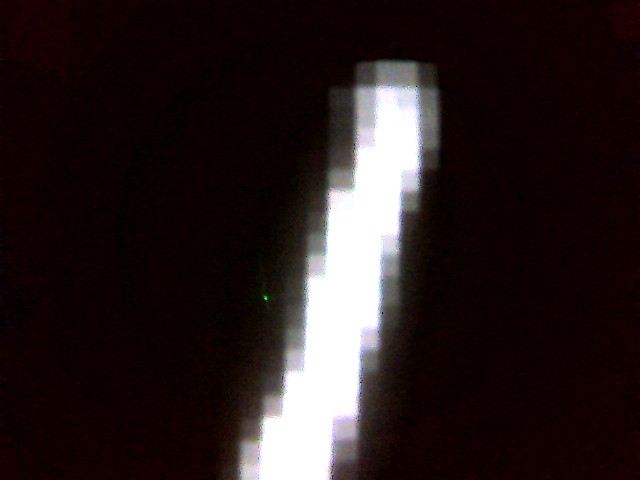

In [ ]:
import cv2
import torch
from time import sleep
from PIL import Image
# import socket
# sleep(4)

cam = cv2.VideoCapture(0)
ret, frame = cam.read()
tensor = torch.from_numpy(frame)
cam.release()

img = Image.fromarray(frame)
im = img.resize((28,28))
im = torch.tensor(np.array(im))
out = a.inference(im)

# send result to esp32
# s = socket.socket()
# s.connect(('192.168.4.1', 80))
# print(out)
# s.send(str(out).encode())
# s.close()


prediction = 0 if out < 0.5 else 1
print(f'Prediction: {prediction}\n {out=}')
img

In [ ]:
batch_size = 32 # samples per batch
num_classes = 2
samples_per_batch_per_class = int(batch_size / num_classes)
samples_per_batch_per_class



imgs/batch = 32
classes = 2
imgs/batch/class = 16 #32/16

16